In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import great_circle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    TimeSeriesSplit,
    cross_val_score,
    cross_val_predict,
    LeaveOneOut,
)
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    make_scorer,
)
import os
import sys

notebook_dir = os.getcwd()
scripts_dir = os.path.abspath(os.path.join(notebook_dir, "..", "scripts"))
if scripts_dir not in sys.path:
    sys.path.append(scripts_dir)

from utils import evaluate_model, evaluate_classification

In [3]:
data = pd.read_csv("../data/GHCND_data.csv")

data["DATE"] = pd.to_datetime(data["DATE"])

columns_to_drop = ["TAVG"]
data = data.drop(columns=columns_to_drop)

data = data.sort_values(by=["STATION", "DATE"])

# Extract month from the DATE
data["MONTH"] = data["DATE"].dt.month

# Seasonal Features
data["MONTH_SIN"] = np.sin(2 * np.pi * data["MONTH"] / 12)
data["MONTH_COS"] = np.cos(2 * np.pi * data["MONTH"] / 12)

## Creating 3 day lags of PRCP, TMAX and TMIN

In [4]:
# Create lag features for the current station
for lag in range(1, 3):
    data[f"PRCP_LAG_{lag}"] = data.groupby("STATION")["PRCP"].shift(lag)
    data[f"TMAX_LAG_{lag}"] = data.groupby("STATION")["TMAX"].shift(lag)
    data[f"TMIN_LAG_{lag}"] = data.groupby("STATION")["TMIN"].shift(lag)

## Finding the nearest 3 stations for each station

In [5]:
# Get unique stations with their coordinates
stations = data[["STATION", "LATITUDE", "LONGITUDE"]].drop_duplicates()


# Function to calculate the distance between two coordinates
def calculate_distance(coord1, coord2):
    return great_circle(coord1, coord2).km


# Create a dictionary to store the three closest neighbors for each station
station_nearby = {}

# Calculate distances and store the three closest neighbors for each station
for i, row1 in stations.iterrows():
    distances = []
    for j, row2 in stations.iterrows():
        if i != j:
            coord1 = (row1["LATITUDE"], row1["LONGITUDE"])
            coord2 = (row2["LATITUDE"], row2["LONGITUDE"])
            distance = calculate_distance(coord1, coord2)
            distances.append((row2["STATION"], distance))
    # Sort by distance and take the three closest neighbors
    distances = sorted(distances, key=lambda x: x[1])[:3]
    station_nearby[row1["STATION"]] = [neighbor[0] for neighbor in distances]

In [6]:
station_nearby

{'GM000003319': ['GME00130786', 'GME00122782', 'GME00120994'],
 'GME00120994': ['GME00132022', 'GM000003319', 'GME00130786'],
 'GME00122782': ['GME00130786', 'GM000003319', 'GME00132322'],
 'GME00129418': ['GME00131470', 'GME00132022', 'GME00120994'],
 'GME00130582': ['GME00131746', 'GME00132322', 'GME00122782'],
 'GME00130786': ['GM000003319', 'GME00122782', 'GME00132022'],
 'GME00131470': ['GME00129418', 'GME00132022', 'GME00120994'],
 'GME00131746': ['GME00132322', 'GME00122782', 'GME00129418'],
 'GME00132022': ['GME00120994', 'GME00130786', 'GME00131470'],
 'GME00132322': ['GME00122782', 'GME00131746', 'GME00130786']}

## Now adding 3 day lags of precipiatationa and temperature of these nearest 3 stations for each station

In [7]:
neighbor_lag_features = pd.DataFrame()

# Create lag features for the three closest neighbors
for station, nearby_stations in station_nearby.items():
    station_data = data[data["STATION"] == station].copy()
    for i, nearby_station in enumerate(nearby_stations):
        for lag in range(1, 3):
            # Create lagged features for the neighboring station
            lagged_cols = data[data["STATION"] == nearby_station][
                ["DATE", "PRCP", "TMAX", "TMIN"]
            ].copy()
            lagged_cols["DATE"] = lagged_cols["DATE"] + pd.Timedelta(days=lag)
            lagged_cols = lagged_cols.rename(
                columns={
                    "PRCP": f"NEIGHBOR_{i+1}_PRCP_LAG_{lag}",
                    "TMAX": f"NEIGHBOR_{i+1}_TMAX_LAG_{lag}",
                    "TMIN": f"NEIGHBOR_{i+1}_TMIN_LAG_{lag}",
                }
            )
            station_data = pd.merge(station_data, lagged_cols, on="DATE", how="left")
    neighbor_lag_features = pd.concat([neighbor_lag_features, station_data], axis=0)

neighbor_lag_features = neighbor_lag_features.loc[
    :, ~neighbor_lag_features.columns.duplicated()
]
neighbor_lag_features = neighbor_lag_features.dropna()

data = neighbor_lag_features

# Evaluation 1: Using fixed train, test dataset

## Creating train and test split, using last 1 year data as test data and remaining as training data

In [8]:
# One-hot encode the STATION column
data = pd.get_dummies(data, columns=["STATION"], drop_first=True)

# Define the test set period
test_period_start = "2023-01-01"

# Split the data into training and test sets based on the DATE
train_data = data[data["DATE"] < test_period_start]
test_data = data[data["DATE"] >= test_period_start]

# Define features and target variable
features = train_data.drop(
    columns=["NAME", "LATITUDE", "LONGITUDE", "ELEVATION", "DATE", "PRCP"]
)
target = train_data["PRCP"]

# Define the same for the test data
test_features = test_data.drop(
    columns=["NAME", "LATITUDE", "LONGITUDE", "ELEVATION", "DATE", "PRCP"]
)
test_target = test_data["PRCP"]

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
test_features_scaled = scaler.transform(test_features)

In [9]:
features.columns

Index(['SNWD', 'TMAX', 'TMIN', 'MONTH', 'MONTH_SIN', 'MONTH_COS', 'PRCP_LAG_1',
       'TMAX_LAG_1', 'TMIN_LAG_1', 'PRCP_LAG_2', 'TMAX_LAG_2', 'TMIN_LAG_2',
       'NEIGHBOR_1_PRCP_LAG_1', 'NEIGHBOR_1_TMAX_LAG_1',
       'NEIGHBOR_1_TMIN_LAG_1', 'NEIGHBOR_1_PRCP_LAG_2',
       'NEIGHBOR_1_TMAX_LAG_2', 'NEIGHBOR_1_TMIN_LAG_2',
       'NEIGHBOR_2_PRCP_LAG_1', 'NEIGHBOR_2_TMAX_LAG_1',
       'NEIGHBOR_2_TMIN_LAG_1', 'NEIGHBOR_2_PRCP_LAG_2',
       'NEIGHBOR_2_TMAX_LAG_2', 'NEIGHBOR_2_TMIN_LAG_2',
       'NEIGHBOR_3_PRCP_LAG_1', 'NEIGHBOR_3_TMAX_LAG_1',
       'NEIGHBOR_3_TMIN_LAG_1', 'NEIGHBOR_3_PRCP_LAG_2',
       'NEIGHBOR_3_TMAX_LAG_2', 'NEIGHBOR_3_TMIN_LAG_2', 'STATION_GME00120994',
       'STATION_GME00122782', 'STATION_GME00129418', 'STATION_GME00130582',
       'STATION_GME00130786', 'STATION_GME00131470', 'STATION_GME00131746',
       'STATION_GME00132022', 'STATION_GME00132322'],
      dtype='object')

## Training Random Forest, XGBoost and Linear regression

In [10]:
rf_model = RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1)
rf_model.fit(features_scaled, target)

xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(features_scaled, target)

lr_model = LinearRegression()
lr_model.fit(features_scaled, target)

LinearRegression()

## Evaluating precipitation predictions

In [11]:
# Predict using the models
rf_predictions = rf_model.predict(test_features_scaled)
xgb_predictions = xgb_model.predict(test_features_scaled)
lr_predictions = lr_model.predict(test_features_scaled)

# Inverse transform the predictions to the original scale
rf_predictions_original = (
    rf_predictions * scaler.scale_[features.columns.get_loc("PRCP_LAG_1")]
    + scaler.mean_[features.columns.get_loc("PRCP_LAG_1")]
)
xgb_predictions_original = (
    xgb_predictions * scaler.scale_[features.columns.get_loc("PRCP_LAG_1")]
    + scaler.mean_[features.columns.get_loc("PRCP_LAG_1")]
)
lr_predictions_original = (
    lr_predictions * scaler.scale_[features.columns.get_loc("PRCP_LAG_1")]
    + scaler.mean_[features.columns.get_loc("PRCP_LAG_1")]
)


# Evaluate the models
rf_evaluation = evaluate_model(rf_predictions, test_target)
xgb_evaluation = evaluate_model(xgb_predictions, test_target)
lr_evaluation = evaluate_model(lr_predictions, test_target)

# Compile the evaluation results into a DataFrame
evaluation_results = pd.DataFrame(
    {
        "Model": ["Random Forest", "XGBoost", "Linear Regression"],
        "MAE": [rf_evaluation[0], xgb_evaluation[0], lr_evaluation[0]],
        "MSE": [rf_evaluation[1], xgb_evaluation[1], lr_evaluation[1]],
        "RMSE": [rf_evaluation[2], xgb_evaluation[2], lr_evaluation[2]],
        "R2": [rf_evaluation[3], xgb_evaluation[3], lr_evaluation[3]],
    }
)

print(evaluation_results)

               Model       MAE        MSE      RMSE        R2
0      Random Forest  2.413677  15.988781  3.998597  0.115764
1            XGBoost  2.435416  17.213598  4.148927  0.048027
2  Linear Regression  2.367552  16.123818  4.015447  0.108296


## Classifying the occurrence of precipitation events > 10 mm/day

In [12]:
threshold = 10  # mm/day
rf_classification = (rf_predictions_original > threshold).astype(int)
xgb_classification = (xgb_predictions_original > threshold).astype(int)
lr_classification = (lr_predictions_original > threshold).astype(int)

# True classification labels
true_classification = (test_target > threshold).astype(int)

rf_classification_metrics = evaluate_classification(
    rf_classification, true_classification
)
xgb_classification_metrics = evaluate_classification(
    xgb_classification, true_classification
)
lr_classification_metrics = evaluate_classification(
    lr_classification, true_classification
)

classification_results = pd.DataFrame(
    {
        "Model": ["Random Forest", "XGBoost", "Linear Regression"],
        "Accuracy": [
            rf_classification_metrics[0],
            xgb_classification_metrics[0],
            lr_classification_metrics[0],
        ],
        "Precision": [
            rf_classification_metrics[1],
            xgb_classification_metrics[1],
            lr_classification_metrics[1],
        ],
        "Recall": [
            rf_classification_metrics[2],
            xgb_classification_metrics[2],
            lr_classification_metrics[2],
        ],
        "F1 Score": [
            rf_classification_metrics[3],
            xgb_classification_metrics[3],
            lr_classification_metrics[3],
        ],
    }
)

print(classification_results)

               Model  Accuracy  Precision    Recall  F1 Score
0      Random Forest  0.648742   0.119497  0.721519  0.205036
1            XGBoost  0.705166   0.119792  0.582278  0.198704
2  Linear Regression  0.729272   0.134884  0.611814  0.221037


In [13]:
data.columns

Index(['NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'PRCP', 'SNWD',
       'TMAX', 'TMIN', 'MONTH', 'MONTH_SIN', 'MONTH_COS', 'PRCP_LAG_1',
       'TMAX_LAG_1', 'TMIN_LAG_1', 'PRCP_LAG_2', 'TMAX_LAG_2', 'TMIN_LAG_2',
       'NEIGHBOR_1_PRCP_LAG_1', 'NEIGHBOR_1_TMAX_LAG_1',
       'NEIGHBOR_1_TMIN_LAG_1', 'NEIGHBOR_1_PRCP_LAG_2',
       'NEIGHBOR_1_TMAX_LAG_2', 'NEIGHBOR_1_TMIN_LAG_2',
       'NEIGHBOR_2_PRCP_LAG_1', 'NEIGHBOR_2_TMAX_LAG_1',
       'NEIGHBOR_2_TMIN_LAG_1', 'NEIGHBOR_2_PRCP_LAG_2',
       'NEIGHBOR_2_TMAX_LAG_2', 'NEIGHBOR_2_TMIN_LAG_2',
       'NEIGHBOR_3_PRCP_LAG_1', 'NEIGHBOR_3_TMAX_LAG_1',
       'NEIGHBOR_3_TMIN_LAG_1', 'NEIGHBOR_3_PRCP_LAG_2',
       'NEIGHBOR_3_TMAX_LAG_2', 'NEIGHBOR_3_TMIN_LAG_2', 'STATION_GME00120994',
       'STATION_GME00122782', 'STATION_GME00129418', 'STATION_GME00130582',
       'STATION_GME00130786', 'STATION_GME00131470', 'STATION_GME00131746',
       'STATION_GME00132022', 'STATION_GME00132322'],
      dtype='object')

/tmp/ipykernel_675221/70348769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['RF_Predictions'] = rf_predictions_original[:len(test_data)]
/tmp/ipykernel_675221/70348769.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['XGB_Predictions'] = xgb_predictions_original[:len(test_data)]
/tmp/ipykernel_675221/70348769.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

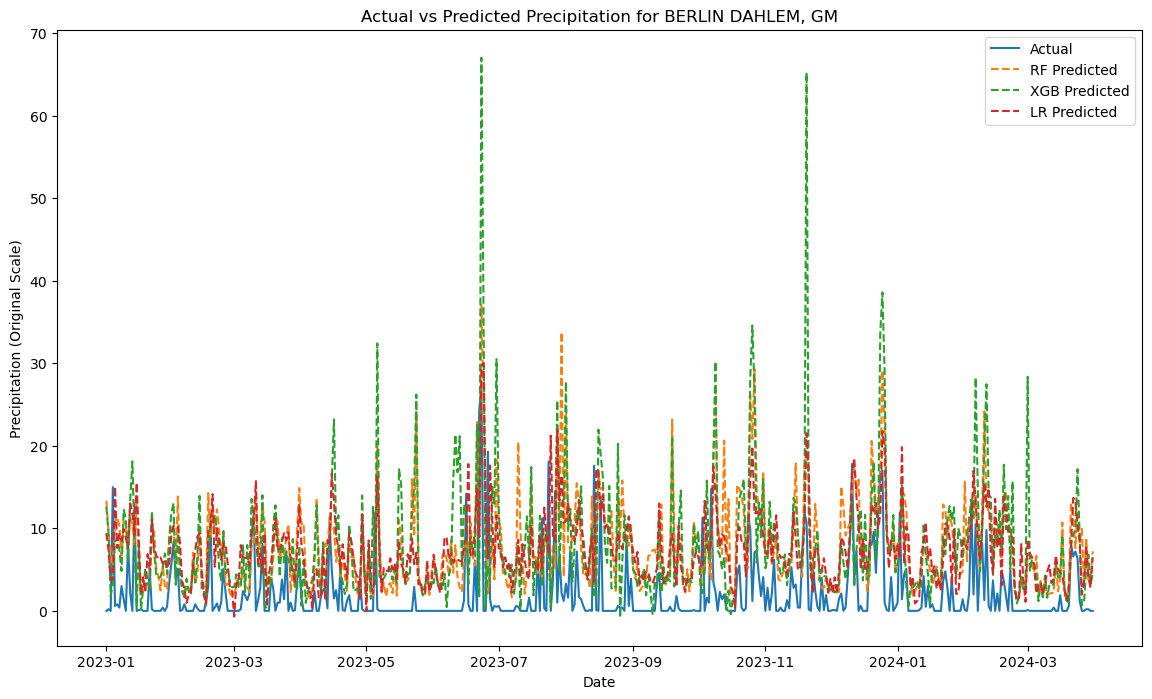

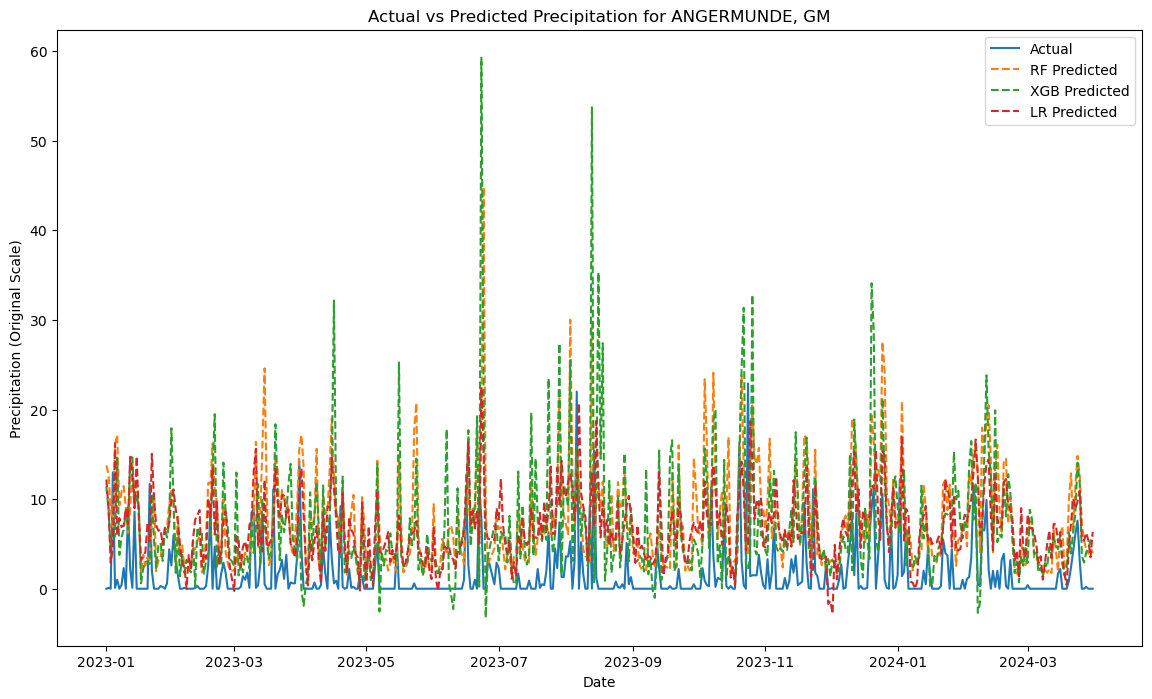

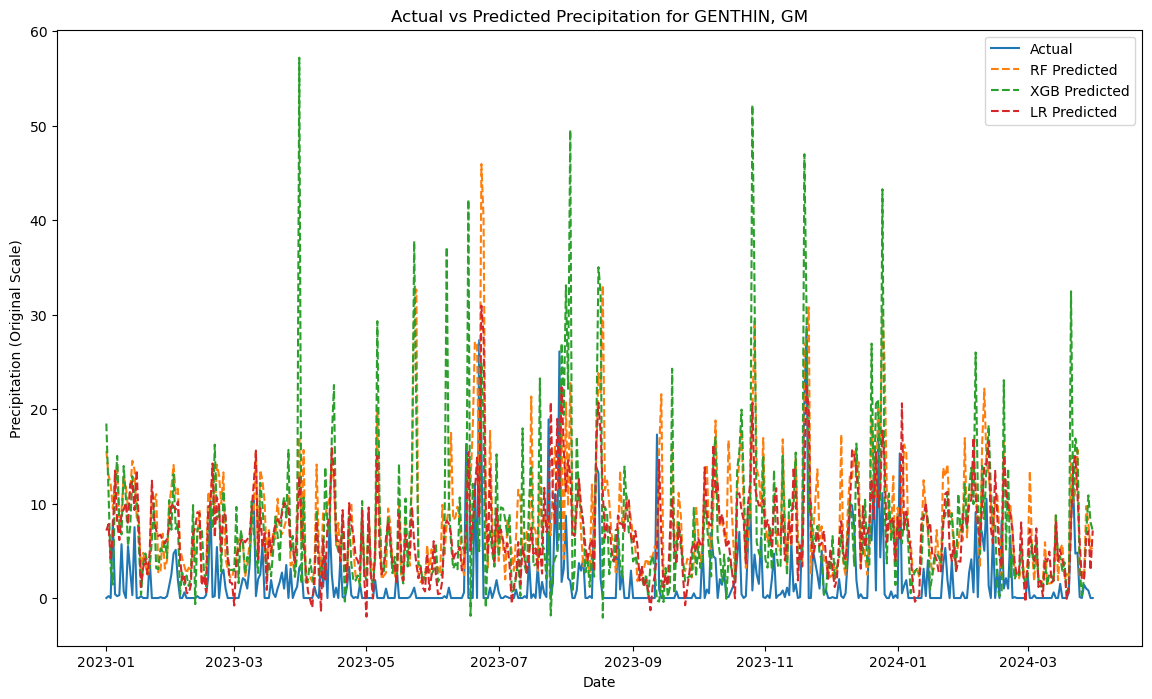

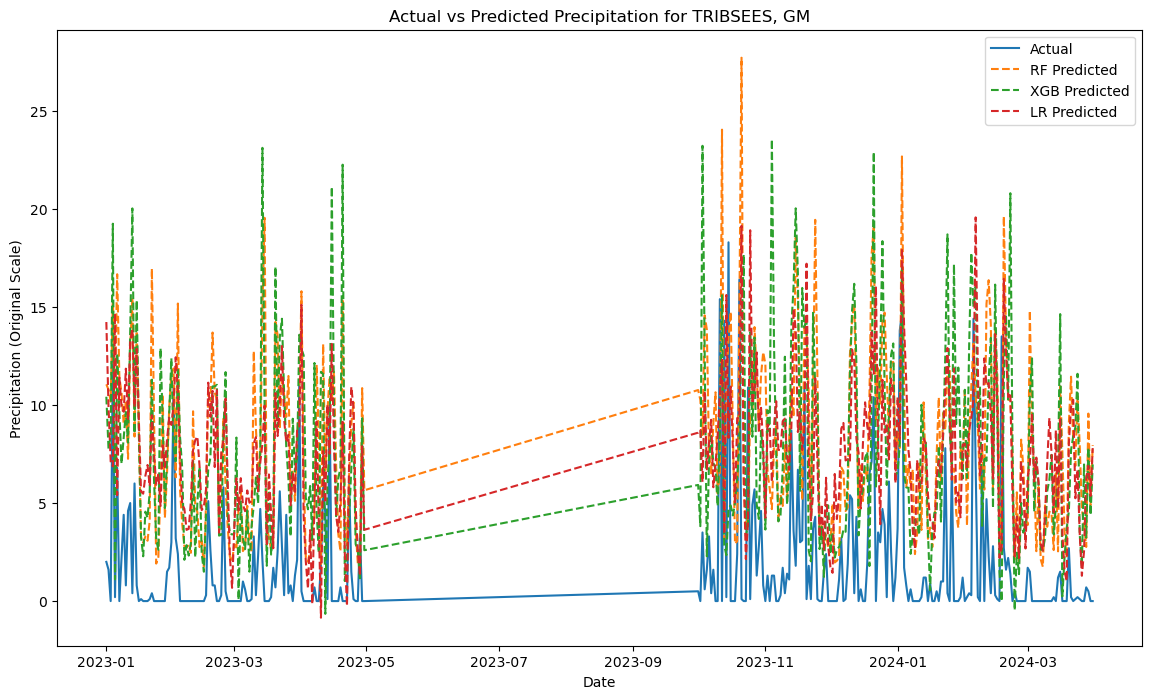

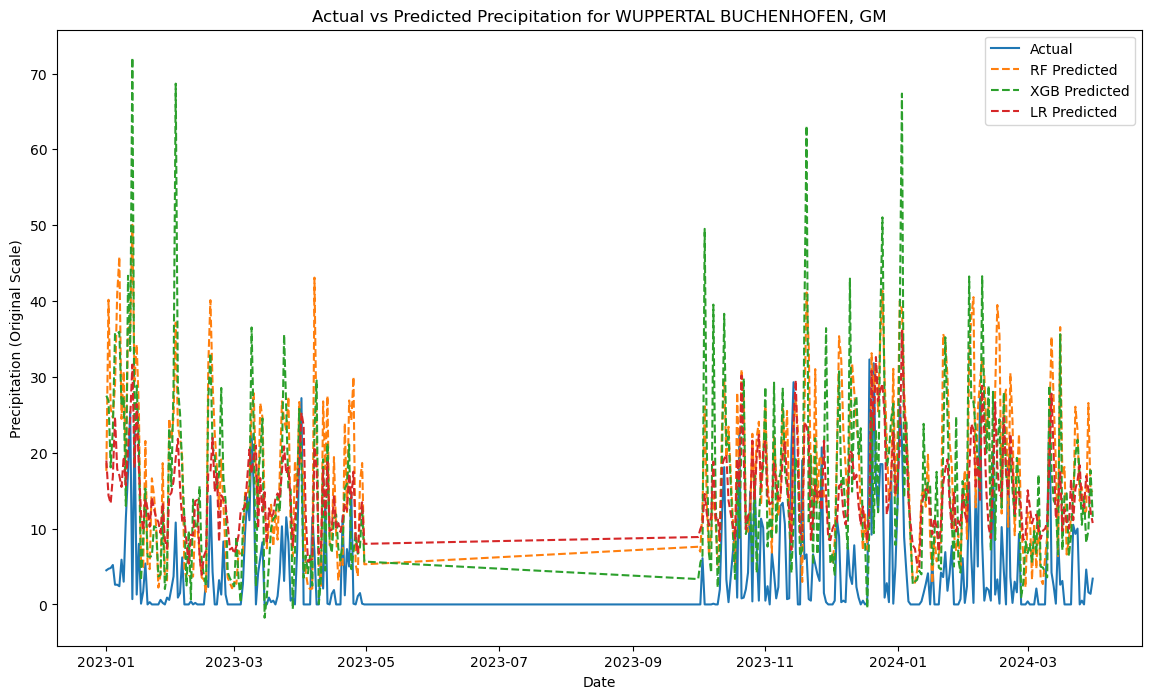

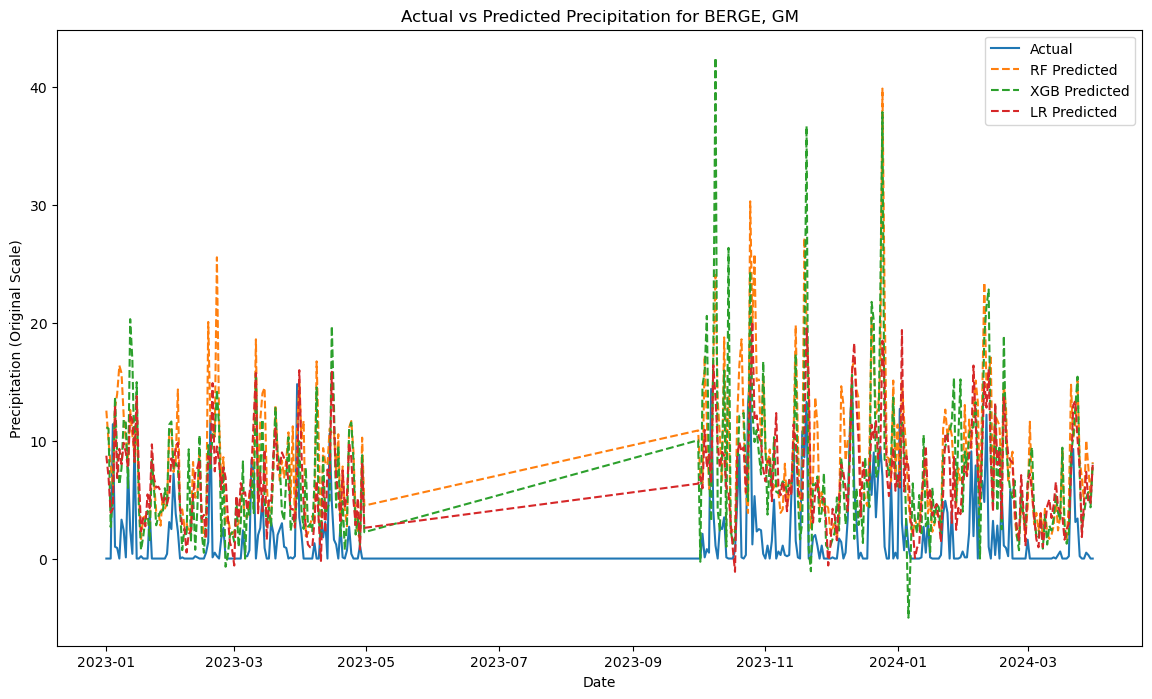

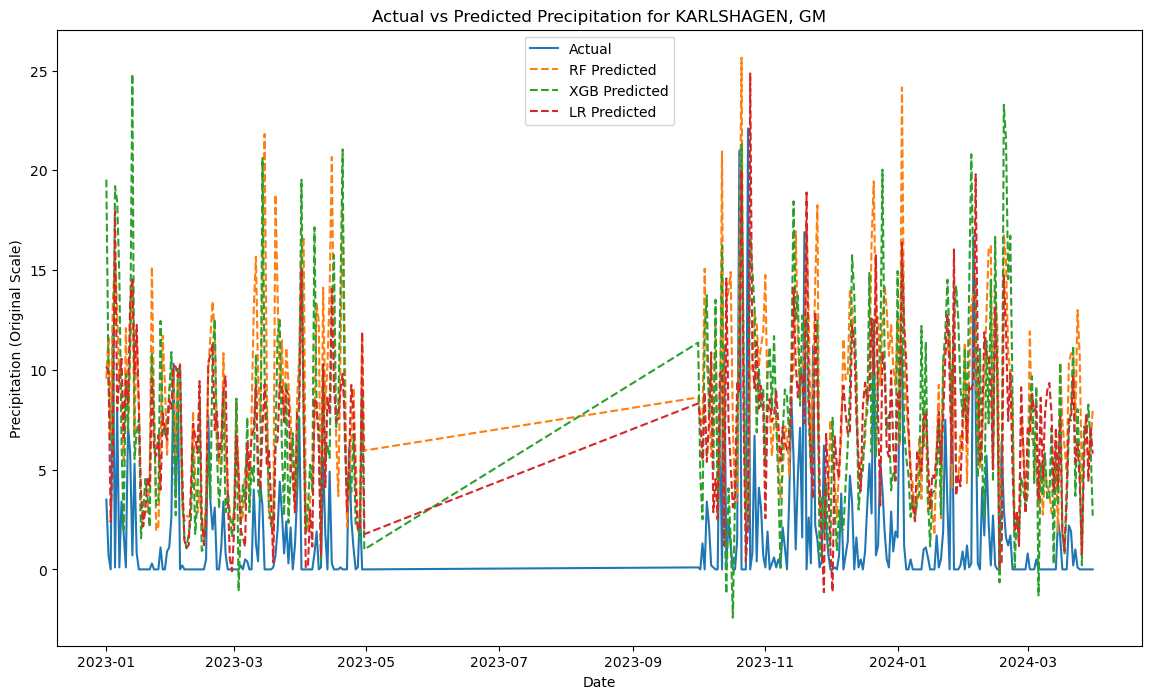

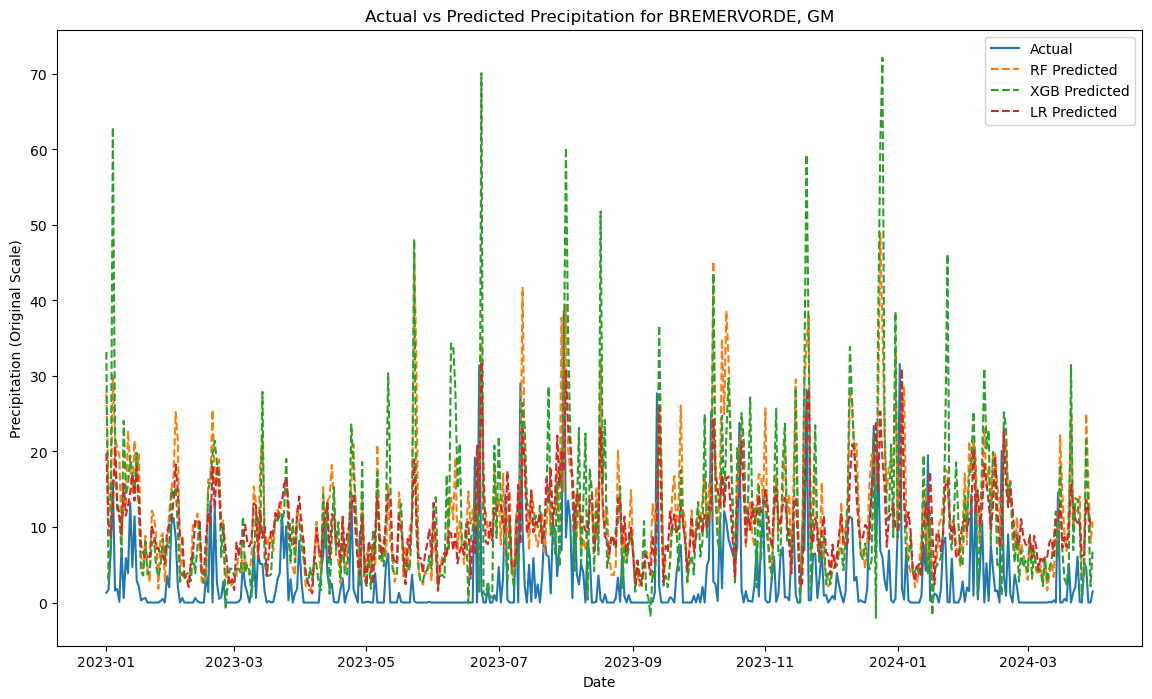

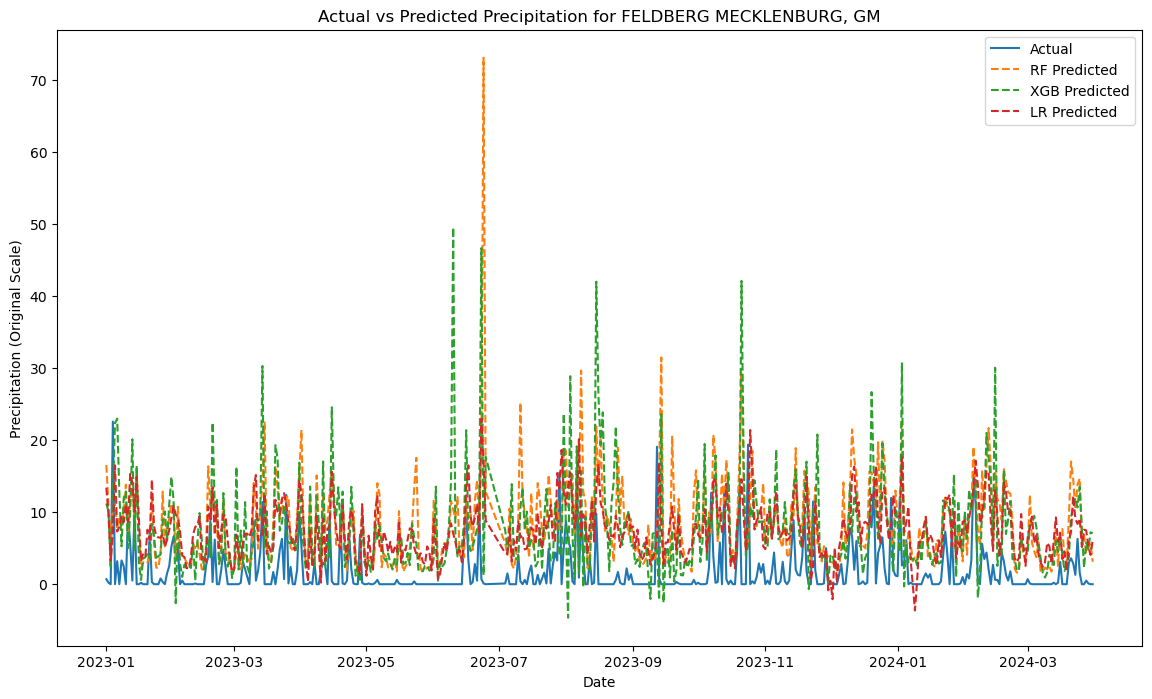

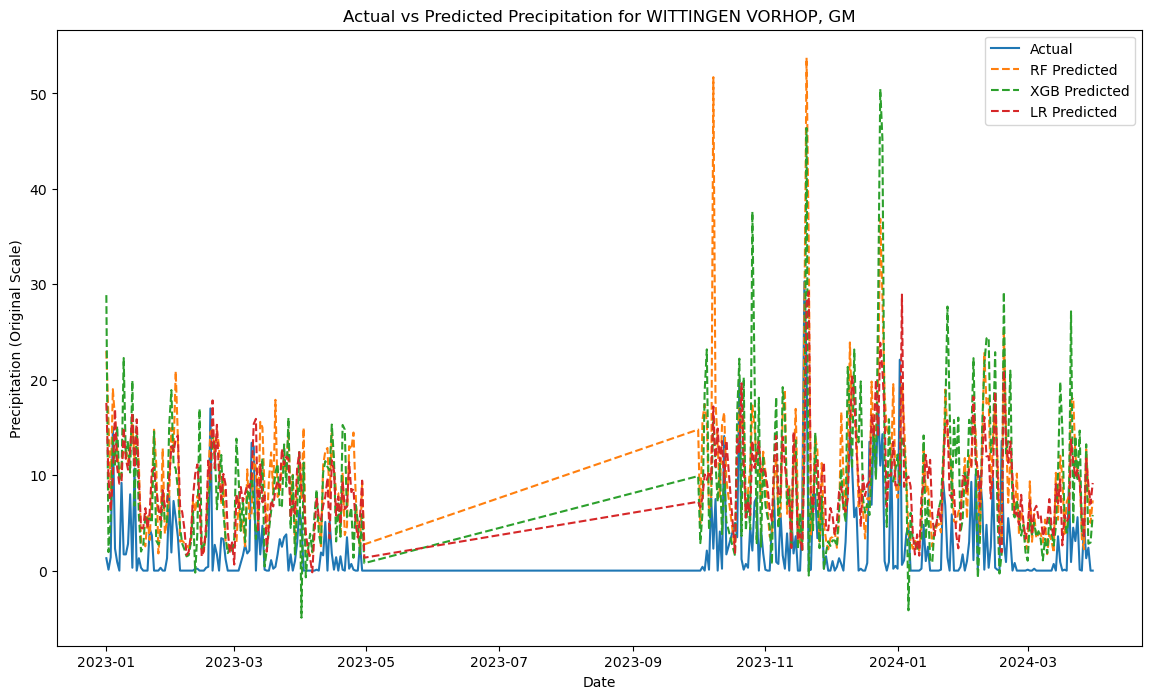

In [14]:
# Include the dates in the test set predictions for plotting
test_data["RF_Predictions"] = rf_predictions_original[: len(test_data)]
test_data["XGB_Predictions"] = xgb_predictions_original[: len(test_data)]
test_data["LR_Predictions"] = lr_predictions_original[: len(test_data)]


def plot_predictions_all_models(station_data, station_name):
    plt.figure(figsize=(14, 8))
    plt.plot(station_data["DATE"], station_data["PRCP"], label="Actual")
    plt.plot(
        station_data["DATE"],
        station_data["RF_Predictions"],
        label="RF Predicted",
        linestyle="--",
    )
    plt.plot(
        station_data["DATE"],
        station_data["XGB_Predictions"],
        label="XGB Predicted",
        linestyle="--",
    )
    plt.plot(
        station_data["DATE"],
        station_data["LR_Predictions"],
        label="LR Predicted",
        linestyle="--",
    )
    plt.xlabel("Date")
    plt.ylabel("Precipitation (Original Scale)")
    plt.title(f"Actual vs Predicted Precipitation for {station_name}")
    plt.legend()
    plt.show()


stations = test_data["NAME"].unique()

for station in stations:
    station_data = test_data[test_data["NAME"] == station]
    plot_predictions_all_models(station_data, station)

# Evaluation 2: Using Time based Cross-Validation

In [15]:
# Time-based cross-validation
tscv = TimeSeriesSplit(n_splits=5)

models = {
    "Random Forest": RandomForestRegressor(
        random_state=42, n_estimators=100, n_jobs=-1
    ),
    "XGBoost": XGBRegressor(random_state=42),
    "Linear Regression": LinearRegression(),
}

# Perform cross-validation for regression and store the predictions
regression_cv_predictions = {}
regression_results = []

for model_name, model in models.items():
    model_predictions = []
    true_values = []

    for train_index, test_index in tscv.split(features_scaled):
        X_train, X_test = features_scaled[train_index], features_scaled[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        model_predictions.extend(predictions)
        true_values.extend(y_test)

    # Store predictions for each model
    regression_cv_predictions[model_name] = np.array(model_predictions)

    mae_scores, mse_scores, rmse_scores, r2_scores = evaluate_model(
        model_predictions, true_values
    )

    regression_results.append(
        {
            "Model": model_name,
            "MAE": mae_scores,
            "MSE": mse_scores,
            "RMSE": rmse_scores,
            "R2": r2_scores,
        }
    )

regression_results_df = pd.DataFrame(regression_results)
print("Regression Results:")
print(regression_results_df)

# Inverse transform the cross-validated predictions to the original scale
for model_name, predictions in regression_cv_predictions.items():
    regression_cv_predictions[model_name] = (
        predictions * scaler.scale_[features.columns.get_loc("PRCP_LAG_1")]
        + scaler.mean_[features.columns.get_loc("PRCP_LAG_1")]
    )

# Perform classification on the cross-validated predictions
classification_threshold = 10  # mm/day

classification_results = []
true_classification = (np.array(true_values) > classification_threshold).astype(
    int
)  # True classification labels

for model_name, predictions_original in regression_cv_predictions.items():
    classification_predictions = (
        predictions_original > classification_threshold
    ).astype(int)

    # Evaluate classification metrics
    accuracy, precision, recall, f1 = evaluate_classification(
        classification_predictions, true_classification
    )

    classification_results.append(
        {
            "Model": model_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
        }
    )

classification_results_df = pd.DataFrame(classification_results)
print("Classification Results:")
print(classification_results_df)

Regression Results:
               Model           MAE           MSE          RMSE            R2
0      Random Forest  1.760742e+00  1.128862e+01  3.359854e+00  1.416603e-01
1            XGBoost  1.765916e+00  1.197739e+01  3.460836e+00  8.928929e-02
2  Linear Regression  3.371652e+08  2.147664e+18  1.465491e+09 -1.632995e+17
Classification Results:
               Model  Accuracy  Precision    Recall  F1 Score
0      Random Forest  0.759593   0.089459  0.743728  0.159708
1            XGBoost  0.795926   0.090933  0.627240  0.158838
2  Linear Regression  0.449876   0.043630  0.808244  0.082790


## Checking the Feature Importance of Random Forest and XGBoost

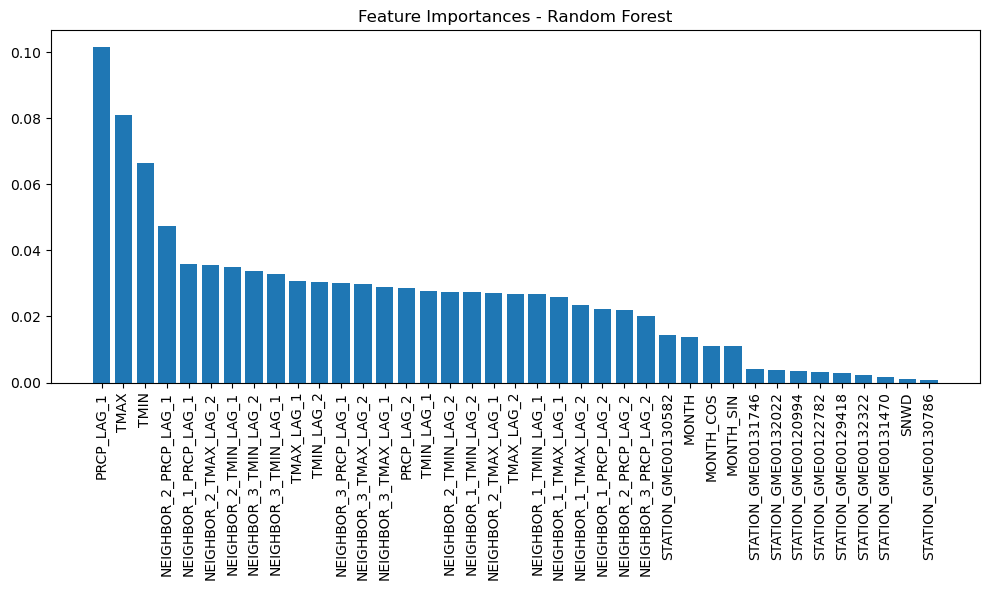

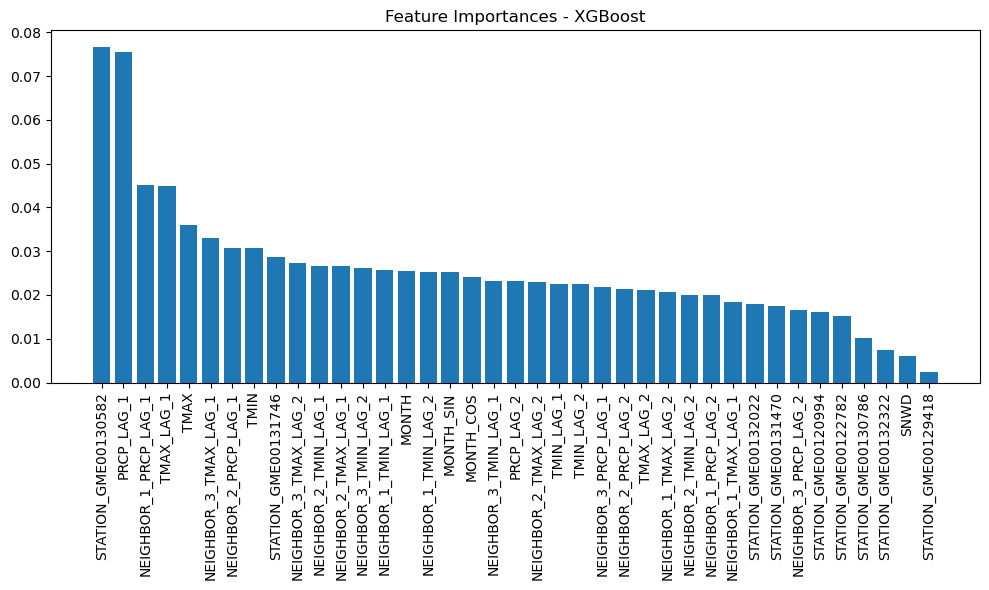

In [16]:
plt.figure(figsize=(10, 6))
rf_importances = rf_model.feature_importances_
rf_indices = np.argsort(rf_importances)[::-1]
plt.title("Feature Importances - Random Forest")
plt.bar(range(len(rf_importances)), rf_importances[rf_indices], align="center")
plt.xticks(
    range(len(rf_importances)), [features.columns[i] for i in rf_indices], rotation=90
)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
xgb_importances = xgb_model.feature_importances_
xgb_indices = np.argsort(xgb_importances)[::-1]
plt.title("Feature Importances - XGBoost")
plt.bar(range(len(xgb_importances)), xgb_importances[xgb_indices], align="center")
plt.xticks(
    range(len(xgb_importances)), [features.columns[i] for i in xgb_indices], rotation=90
)
plt.tight_layout()
plt.show()